In [226]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima,ARIMA
from sklearn.model_selection import GridSearchCV
import numpy as np

In [2]:
#read the dataset
data=pd.read_excel("Sales_Forecast_Data.xlsx")

In [3]:
data

,FIN_YEAR,MONTH,STATE,FG,DISTRICT,COMPANY,VALUE
0,2014-2015,Nov,Haryana,Insecticides,Rohtak,monous,675.00
1,2014-2015,Nov,Haryana,Insecticides,Rewari,monous,73.71
2,2014-2015,Nov,Haryana,Insecticides,Gurgaon,monous,405.00
3,2014-2015,Nov,Haryana,Insecticides,Mewat,monous,1188.00
4,2014-2015,Nov,Haryana,Insecticides,Palwal,monous,5188.59
...,...,...,...,...,...,...,...
230147,2016-2017,Dec,Uttar Pradesh,Bactericides,Etah,ABC Manufacturing,0.00
230148,2016-2017,Dec,Uttar Pradesh,Bactericides,Bulandshahr,disescent,6.75
230149,2016-2017,Dec,Uttar Pradesh,Bactericides,Lucknow,disescent,0.00
230150,2016-2017,Dec,Uttar Pradesh,Bactericides,Basti,disescent,486.00


In [4]:
#check for null values
data.isna().sum()
#there are no null values in the dataset

FIN_YEAR    0
MONTH       0
STATE       0
FG          0
DISTRICT    0
COMPANY     0
VALUE       0
dtype: int64

Since the problem statement is about :"STATE WISE FORECAST OF PESTICIDES SALES FOR ABC MANUFACTURING"

Separating the ABC Manufacturing dataset from whole dataset

In [5]:
dataset=data.loc[data['COMPANY']=='ABC Manufacturing']
dataset=dataset.reset_index()
dataset.drop("index",axis=1,inplace=True)
dataset

,FIN_YEAR,MONTH,STATE,FG,DISTRICT,COMPANY,VALUE
0,2014-2015,Dec,Haryana,Insecticides,Ambala,ABC Manufacturing,6019.380
1,2014-2015,Dec,Haryana,Insecticides,Yamunanagar,ABC Manufacturing,425.250
2,2014-2015,Dec,Haryana,Insecticides,Karnal,ABC Manufacturing,14782.635
3,2014-2015,Dec,Haryana,Insecticides,Panipat,ABC Manufacturing,4031.910
4,2014-2015,Dec,Haryana,Insecticides,Sonipat,ABC Manufacturing,8692.110
...,...,...,...,...,...,...,...
28635,2016-2017,Feb,Punjab,Bactericides,Barnala,ABC Manufacturing,0.000
28636,2016-2017,Dec,Uttar Pradesh,Bactericides,Faizabad,ABC Manufacturing,0.000
28637,2016-2017,Dec,Uttar Pradesh,Bactericides,Basti,ABC Manufacturing,0.000
28638,2016-2017,Dec,Uttar Pradesh,Bactericides,Ballia,ABC Manufacturing,0.000


Data preprocessing to the year and month columns,inorder to derive the date from the given data


In [6]:
#renaming the month column to numbers
dataset['MONTH'] = dataset['MONTH'].str.replace('Jan', '1')
dataset['MONTH'] = dataset['MONTH'].str.replace('Feb', '2')
dataset['MONTH'] = dataset['MONTH'].str.replace('Mar', '3')
dataset['MONTH'] = dataset['MONTH'].str.replace('Apr', '4')
dataset['MONTH'] = dataset['MONTH'].str.replace('May', '5')
dataset['MONTH'] = dataset['MONTH'].str.replace('Jun', '6')
dataset['MONTH'] = dataset['MONTH'].str.replace('Jul', '7')
dataset['MONTH'] = dataset['MONTH'].str.replace('Aug', '8')
dataset['MONTH'] = dataset['MONTH'].str.replace('Sep', '9')
dataset['MONTH'] = dataset['MONTH'].str.replace('Oct', '10')
dataset['MONTH'] = dataset['MONTH'].str.replace('Nov', '11')
dataset['MONTH'] = dataset['MONTH'].str.replace('Dec', '12')


In [7]:
#seperating the datasets with respect to months 
jan_data=dataset.loc[dataset['MONTH']=="1"]
feb_data=dataset.loc[dataset['MONTH']=="2"]
mar_data=dataset.loc[dataset['MONTH']=="3"]
apr_data=dataset.loc[dataset['MONTH']=="4"]
may_data=dataset.loc[dataset['MONTH']=="5"]
jun_data=dataset.loc[dataset['MONTH']=="6"]
jul_data=dataset.loc[dataset['MONTH']=="7"]
aug_data=dataset.loc[dataset['MONTH']=="8"]
sep_data=dataset.loc[dataset['MONTH']=="9"]
oct_data=dataset.loc[dataset['MONTH']=="10"]
nov_data=dataset.loc[dataset['MONTH']=="11"]
dec_data=dataset.loc[dataset['MONTH']=="12"]

In [8]:
#combining the data into quarters
Q4_data=pd.concat([jan_data,feb_data,mar_data]).reset_index().drop("index",axis=1)
Q1_data=pd.concat([apr_data,may_data,jun_data]).reset_index().drop("index",axis=1)
Q2_data=pd.concat([jul_data,aug_data,sep_data]).reset_index().drop("index",axis=1)
Q3_data=pd.concat([oct_data,nov_data,dec_data]).reset_index().drop("index",axis=1)

In [9]:
#since the Q4 data falls into a new year in the year cycle we need to rename the year to latter year in cycle
#that is 2014-2015  jan(2015) so rename the year to 2015
Q4_data['FIN_YEAR'] = Q4_data['FIN_YEAR'].str.replace('2014-2015', '2015')
Q4_data['FIN_YEAR'] = Q4_data['FIN_YEAR'].str.replace('2015-2016', '2016')
Q4_data['FIN_YEAR'] = Q4_data['FIN_YEAR'].str.replace('2016-2017', '2017')
Q4_data['FIN_YEAR'] = Q4_data['FIN_YEAR'].str.replace('2017-2018', '2018')

Q1_data['FIN_YEAR'] = Q1_data['FIN_YEAR'].str.replace('2014-2015', '2014')
Q1_data['FIN_YEAR'] = Q1_data['FIN_YEAR'].str.replace('2015-2016', '2015')
Q1_data['FIN_YEAR'] = Q1_data['FIN_YEAR'].str.replace('2016-2017', '2016')
Q1_data['FIN_YEAR'] = Q1_data['FIN_YEAR'].str.replace('2017-2018', '2017')

Q2_data['FIN_YEAR'] = Q2_data['FIN_YEAR'].str.replace('2014-2015', '2014')
Q2_data['FIN_YEAR'] = Q2_data['FIN_YEAR'].str.replace('2015-2016', '2015')
Q2_data['FIN_YEAR'] = Q2_data['FIN_YEAR'].str.replace('2016-2017', '2016')
Q2_data['FIN_YEAR'] = Q2_data['FIN_YEAR'].str.replace('2017-2018', '2017')

Q3_data['FIN_YEAR'] = Q3_data['FIN_YEAR'].str.replace('2014-2015', '2014')
Q3_data['FIN_YEAR'] = Q3_data['FIN_YEAR'].str.replace('2015-2016', '2015')
Q3_data['FIN_YEAR'] = Q3_data['FIN_YEAR'].str.replace('2016-2017', '2016')
Q3_data['FIN_YEAR'] = Q3_data['FIN_YEAR'].str.replace('2017-2018', '2017')

In [13]:
#combining the quarters data in to a dataset
dataset_new=pd.concat([Q1_data,Q2_data,Q3_data,Q4_data]).reset_index().drop("index",axis=1)

In [14]:
dataset_new["date"]=pd.to_datetime(dataset_new["FIN_YEAR"]+"-"+dataset_new["MONTH"]+"-"+"1")

In [15]:
#removing the unnecessary columns
dataset_new.drop(["FIN_YEAR","MONTH",'FG','DISTRICT','COMPANY'],axis=1,inplace=True)

In [16]:
dataset_new

,STATE,VALUE,date
0,Haryana,438.750,2014-04-01
1,Haryana,89.100,2014-04-01
2,Haryana,2937.060,2014-04-01
3,Haryana,3034.125,2014-04-01
4,Haryana,5320.890,2014-04-01
...,...,...,...
28635,Punjab,0.000,2017-03-01
28636,Punjab,0.000,2017-03-01
28637,Punjab,0.000,2017-03-01
28638,Punjab,0.000,2017-03-01


In [17]:
#the problem statement wnat to build a forecast model for the sales in every state 
#getting the count and number of states in the dataset
dataset_new.STATE.value_counts()

Uttar Pradesh       13024
Haryana              6028
Himachal Pradesh     3880
Punjab               3668
Uttarakhand          2040
Name: STATE, dtype: int64

In [18]:
#first creation of seperate detasets for each state:
Himachal_dataset=dataset_new.loc[dataset_new['STATE']=='Himachal Pradesh']
Haryana_dataset=dataset_new.loc[dataset_new['STATE']=='Haryana']
Uttar_Pradesh_dataset=dataset_new.loc[dataset_new['STATE']=='Uttar Pradesh']
Punjab_dataset=dataset_new.loc[dataset_new['STATE']=='Punjab']
Uttarakhand_dataset=dataset_new.loc[dataset_new['STATE']=='Uttarakhand']

In [19]:
#drop the state column in all datasets
Himachal_dataset.drop(["STATE"],axis=1,inplace=True)
Haryana_dataset.drop(["STATE"],axis=1,inplace=True)
Uttar_Pradesh_dataset.drop(["STATE"],axis=1,inplace=True)
Punjab_dataset.drop(["STATE"],axis=1,inplace=True)
Uttarakhand_dataset.drop(["STATE"],axis=1,inplace=True)

C:\Users\91738\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [20]:
#rearranging the datasets in cronological order
Himachal_dataset=Himachal_dataset.sort_values("date").reset_index().drop("index",axis=1)
Haryana_dataset=Haryana_dataset.sort_values("date").reset_index().drop("index",axis=1)
Uttarakhand_dataset=Uttarakhand_dataset.sort_values("date").reset_index().drop("index",axis=1)
Punjab_dataset=Punjab_dataset.sort_values("date").reset_index().drop("index",axis=1)
Uttar_Pradesh_dataset=Uttar_Pradesh_dataset.sort_values("date").reset_index().drop("index",axis=1)

In [21]:
#adding the monthly sales 
Uttarakhand_dataset=Uttarakhand_dataset.groupby('date')['VALUE'].sum().reset_index()
Punjab_dataset=Punjab_dataset.groupby('date')['VALUE'].sum().reset_index()
Uttar_Pradesh_dataset=Uttar_Pradesh_dataset.groupby('date')['VALUE'].sum().reset_index()
Haryana_dataset=Haryana_dataset.groupby('date')['VALUE'].sum().reset_index()
Himachal_dataset=Himachal_dataset.groupby('date')['VALUE'].sum().reset_index()


In [22]:
#setting the date as index
Punjab_dataset.set_index("date",inplace=True)
Uttarakhand_dataset.set_index("date",inplace=True)
Uttar_Pradesh_dataset.set_index("date",inplace=True)
Haryana_dataset.set_index("date",inplace=True)
Himachal_dataset.set_index("date",inplace=True)

<AxesSubplot:xlabel='date'>

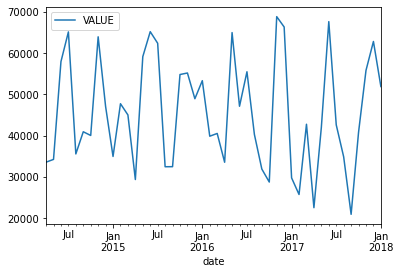

In [23]:
Uttarakhand_dataset.plot()

<AxesSubplot:xlabel='date'>

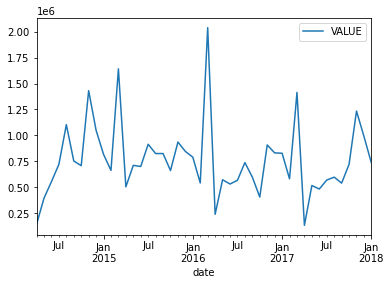

In [24]:
Uttar_Pradesh_dataset.plot()

<AxesSubplot:xlabel='date'>

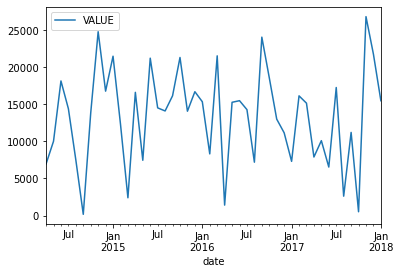

In [25]:
Himachal_dataset.plot()

<AxesSubplot:xlabel='date'>

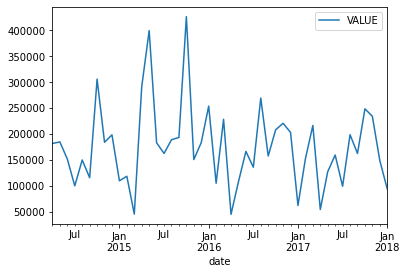

In [26]:
Punjab_dataset.plot()

<AxesSubplot:xlabel='date'>

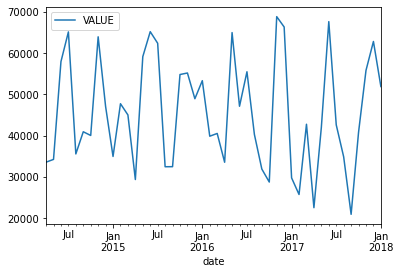

In [27]:
Uttarakhand_dataset.plot()


In [28]:
#it is evident there is a seasonality in the data there is upward trend in january-march and fall followed by 
#rise around september to december

#note: i may be wrong here please see the graphs below for furthur clear month details

In [29]:
#split the data into train,test
train_Himachal_dataset=Himachal_dataset[0:33]
test_Himachal_dataset=Himachal_dataset[33:]
train_Punjab_dataset=Punjab_dataset[0:33]
test_Punjab_dataset=Punjab_dataset[33:]
train_Uttarakhand_dataset=Uttarakhand_dataset[0:33]
test_Uttarakhand_dataset=Uttarakhand_dataset[33:]
train_Haryana_dataset=Haryana_dataset[0:33]
test_Haryana_dataset=Haryana_dataset[33:]
train_Uttar_Pradesh_dataset=Uttar_Pradesh_dataset[0:33]
test_Uttar_Pradesh_dataset=Uttar_Pradesh_dataset[33:]

<AxesSubplot:xlabel='date'>

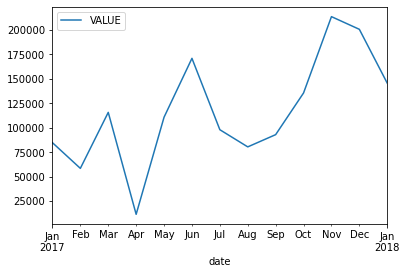

In [30]:
test_Haryana_dataset.plot()
#write the trend observations here

<AxesSubplot:xlabel='date'>

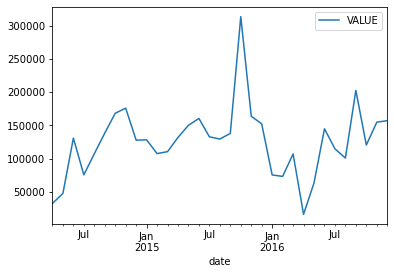

In [31]:
train_Haryana_dataset.plot()

In [32]:
#checking for the stationarity of the dataset
#for which we use the ad fuller test
datasets=[train_Haryana_dataset,train_Haryana_dataset,train_Punjab_dataset,train_Uttar_Pradesh_dataset,train_Uttarakhand_dataset]
for i in datasets:
    print("###############")
    result=adfuller(i)
    print(f'ADF Statistic: {result[0]}')
    print(f'n_lags: {result[1]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}') 


###############
ADF Statistic: -4.076760766814591
n_lags: 0.0010578267145618697
p-value: 0.0010578267145618697
Critial Values:
   1%, -3.653519805908203
Critial Values:
   5%, -2.9572185644531253
Critial Values:
   10%, -2.6175881640625
###############
ADF Statistic: -4.076760766814591
n_lags: 0.0010578267145618697
p-value: 0.0010578267145618697
Critial Values:
   1%, -3.653519805908203
Critial Values:
   5%, -2.9572185644531253
Critial Values:
   10%, -2.6175881640625
###############
ADF Statistic: -5.312836676748563
n_lags: 5.150172496458375e-06
p-value: 5.150172496458375e-06
Critial Values:
   1%, -3.653519805908203
Critial Values:
   5%, -2.9572185644531253
Critial Values:
   10%, -2.6175881640625
###############
ADF Statistic: -6.601570648379313
n_lags: 6.715373274570674e-09
p-value: 6.715373274570674e-09
Critial Values:
   1%, -3.653519805908203
Critial Values:
   5%, -2.9572185644531253
Critial Values:
   10%, -2.6175881640625
###############
ADF Statistic: -2.0461940294722756
n

In [33]:
#the data is not stationary


In [ ]:
#MODEL BUILDING A SIMPLE ARIMA MODEL

In [218]:
## Model
arimaModel1 = ARIMA((2,1,0), (1,1,0,12)).fit(train_Haryana_dataset)
Forecast = pd.Series(arimaModel.predict(13))
Forecast

Forecast.index = test_Haryana_dataset.index
Forecast

Forecast_Haryana = pd.concat([Haryana_dataset, Forecast], axis = 1)

Forecast_Haryana.rename(columns={0:"Forecast"},inplace=True)

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<AxesSubplot:xlabel='date'>

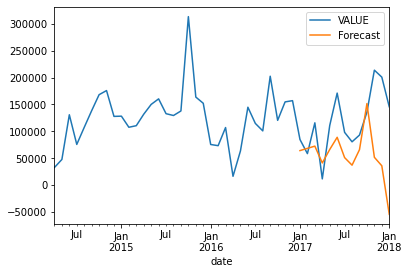

In [219]:
Forecast_Haryana.plot()

In [220]:
## Validation
Validation_Df = Forecast_Haryana[33:].copy()
np.mean(abs(Validation_Df['VALUE'] - Validation_Df['Forecast'])/Validation_Df['VALUE'])*100 # MAPE

66.79206873498393

In [221]:
np.sqrt(np.mean((Validation_Df['VALUE'] - Validation_Df['Forecast'])**2)) # RMSE

92310.922590623

In [222]:
#TRYING THE LOG TRANSFORMATION on the same model
train=np.log(train_Haryana_dataset)
arimaModel2 = ARIMA((2,1,0), (1,1,0,12)).fit(train)
Forecast = pd.Series(arimaModel2.predict(13))
Forecast = np.exp(Forecast)
Forecast.index = test_Haryana_dataset.index # Needed for the pd.concat to work correctly in the next line

Forecast_Haryana = pd.concat([Haryana_dataset, Forecast], axis = 1)

Forecast_Haryana.rename(columns={0:"Forecast"},inplace=True)

C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<AxesSubplot:xlabel='date'>

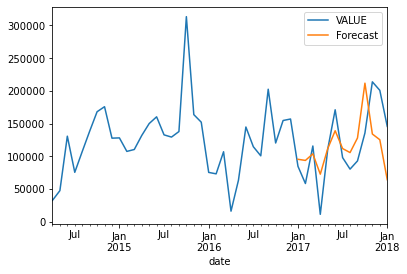

In [223]:
Forecast_Haryana.plot()

In [224]:
Validation_Df = Forecast_Haryana[33:].copy()
np.mean(abs(Validation_Df['VALUE'] - Validation_Df['Forecast'])/Validation_Df['VALUE'])*100 # MAPE

70.43481383287245

In [225]:
np.sqrt(np.mean((Validation_Df['VALUE'] - Validation_Df['Forecast'])**2)) # RMSE

50251.24024423529

In [188]:
#grid search on model 1 for better p,d,q,P,D,Q values
p = range(0,2)
d = range(0,2)
q = range(0,2)
P = range(2)
D = range(2)
Q = range(2)

pList = []
dList = []
qList = []
PList = []
DList = []
QList = []
mapeList = []
seasonalPDQList = []

for i in p:
    for j in d:
        for k in q:
            for I in P:
                for J in D:
                    for K in Q:
            
                        print(i,j,k, I, J, K)
                        tempArimaModel = ARIMA((i,j,k), (I,J,K,12)).fit(train_Haryana_dataset)
                        
                        Forecast = pd.Series(tempArimaModel.predict(13)).rename('Forecast')
                        Forecast.index = test_Haryana_dataset.index
                        Actual_Forecast_Df = pd.concat([Haryana_dataset, Forecast], axis = 1)
                        Validation_Df = Actual_Forecast_Df[-13:].copy()
                        tempMAPE = np.mean(abs(Validation_Df['VALUE'] - Validation_Df['Forecast'])/Validation_Df['VALUE'])*100 # MAPE
                        
                        pList.append(i)
                        dList.append(j)
                        qList.append(k)
                        PList.append(I)
                        DList.append(J)
                        QList.append(K)
                        mapeList.append(tempMAPE)
            
            
arimaEvaluationDf = pd.DataFrame({"p": pList,
                             "d": dList,
                             "q": qList,
                             "P": PList,
                             "D": DList,
                             "Q": QList,
                             "MAPE": mapeList})

0 0 0 0 0 0
0 0 0 0 0 1
0 0 0 0 1 0
0 0 0 0 1 1
0 0 0 1 0 0
0 0 0 1 0 1
0 0 0 1 1 0
0 0 0 1 1 1
0 0 1 0 0 0


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary star

0 0 1 0 0 1
0 0 1 0 1 0
0 0 1 0 1 1
0 0 1 1 0 0
0 0 1 1 0 1
0 0 1 1 1 0
0 0 1 1 1 1


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary star

0 1 0 0 0 0
0 1 0 0 0 1
0 1 0 0 1 0
0 1 0 0 1 1
0 1 0 1 0 0
0 1 0 1 0 1
0 1 0 1 1 0


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. A

0 1 0 1 1 1
0 1 1 0 0 0
0 1 1 0 0 1
0 1 1 0 1 0
0 1 1 0 1 1


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


0 1 1 1 0 0
0 1 1 1 0 1
0 1 1 1 1 0
0 1 1 1 1 1


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


1 0 0 0 0 0
1 0 0 0 0 1
1 0 0 0 1 0
1 0 0 0 1 1
1 0 0 1 0 0
1 0 0 1 0 1
1 0 0 1 1 0


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary star

1 0 0 1 1 1
1 0 1 0 0 0
1 0 1 0 0 1
1 0 1 0 1 0
1 0 1 0 1 1


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\91738\anaconda3\lib\s

1 0 1 1 0 0
1 0 1 1 0 1
1 0 1 1 1 0
1 0 1 1 1 1


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\91738\anaconda3

1 1 0 0 0 0
1 1 0 0 0 1
1 1 0 0 1 0
1 1 0 0 1 1
1 1 0 1 0 0
1 1 0 1 0 1
1 1 0 1 1 0


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


1 1 0 1 1 1
1 1 1 0 0 0
1 1 1 0 0 1
1 1 1 0 1 0
1 1 1 0 1 1
1 1 1 1 0 0


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


1 1 1 1 0 1
1 1 1 1 1 0
1 1 1 1 1 1


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [189]:
arimaEvaluationDf.MAPE.sort_values()

34     30.793300
2      31.314347
7      32.218644
6      35.294884
14     35.462199
         ...    
20    184.888345
17    186.507340
58    186.546618
26    253.718227
27    304.053897
Name: MAPE, Length: 64, dtype: float64

In [190]:
arimaEvaluationDf.iloc[34]

p        1.0000
d        0.0000
q        0.0000
P        0.0000
D        1.0000
Q        0.0000
MAPE    30.7933
Name: 34, dtype: float64

In [175]:
#grid search on model 2
p = range(0,2)
d = range(0,2)
q = range(0,2)
P = range(2)
D = range(2)
Q = range(2)

pList = []
dList = []
qList = []
PList = []
DList = []
QList = []
mapeList = []
seasonalPDQList = []

for i in p:
    for j in d:
        for k in q:
            for I in P:
                for J in D:
                    for K in Q:
            
                        print(i,j,k, I, J, K)
                        train=np.log(train_Haryana_dataset)
                        tempArimaModel = ARIMA((i,j,k), (I,J,K,12)).fit(train)
                        
                        Forecast = pd.Series(tempArimaModel.predict(13)).rename('Forecast')
                        Forecast = np.exp(Forecast)
                        Forecast.index = test_Haryana_dataset.index
                        Actual_Forecast_Df = pd.concat([Haryana_dataset, Forecast], axis = 1)
                        Validation_Df = Actual_Forecast_Df[-13:].copy()
                        tempMAPE = np.mean(abs(Validation_Df['VALUE'] - Validation_Df['Forecast'])/Validation_Df['VALUE'])*100 # MAPE
                        
                        pList.append(i)
                        dList.append(j)
                        qList.append(k)
                        PList.append(I)
                        DList.append(J)
                        QList.append(K)
                        mapeList.append(tempMAPE)
            
            
arimaEvaluationDf = pd.DataFrame({"p": pList,
                             "d": dList,
                             "q": qList,
                             "P": PList,
                             "D": DList,
                             "Q": QList,
                             "MAPE": mapeList})


0 0 0 0 0 0
0 0 0 0 0 1
0 0 0 0 1 0
0 0 0 0 1 1
0 0 0 1 0 0


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


0 0 0 1 0 1
0 0 0 1 1 0
0 0 0 1 1 1
0 0 1 0 0 0


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too 

0 0 1 0 0 1
0 0 1 0 1 0
0 0 1 0 1 1
0 0 1 1 0 0


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters e

0 0 1 1 0 1
0 0 1 1 1 0


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


0 0 1 1 1 1
0 1 0 0 0 0
0 1 0 0 0 1
0 1 0 0 1 0
0 1 0 0 1 1


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


0 1 0 1 0 0
0 1 0 1 0 1


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too 

0 1 0 1 1 0
0 1 0 1 1 1
0 1 1 0 0 0
0 1 1 0 0 1
0 1 1 0 1 0
0 1 1 0 1 1
0 1 1 1 0 0
0 1 1 1 0 1


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


0 1 1 1 1 0
0 1 1 1 1 1
1 0 0 0 0 0
1 0 0 0 0 1


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


1 0 0 0 1 0
1 0 0 0 1 1
1 0 0 1 0 0


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  wa

1 0 0 1 0 1
1 0 0 1 1 0
1 0 0 1 1 1
1 0 1 0 0 0
1 0 1 0 0 1


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


1 0 1 0 1 0
1 0 1 0 1 1


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\91738\anaconda3\lib\s

1 0 1 1 0 0


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1 0 1 1 0 1
1 0 1 1 1 0


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\91738\anaconda3

1 0 1 1 1 1
1 1 0 0 0 0
1 1 0 0 0 1


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


1 1 0 0 1 0
1 1 0 0 1 1
1 1 0 1 0 0
1 1 0 1 0 1


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too 

1 1 0 1 1 0
1 1 0 1 1 1


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


1 1 1 0 0 0
1 1 1 0 0 1
1 1 1 0 1 0
1 1 1 0 1 1
1 1 1 1 0 0


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


1 1 1 1 0 1
1 1 1 1 1 0


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


1 1 1 1 1 1


C:\Users\91738\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [185]:
arimaEvaluationDf.MAPE.sort_values()

34     30.793300
2      31.314347
7      32.218644
6      35.294884
14     35.462199
         ...    
20    184.888345
17    186.507340
58    186.546618
26    253.718227
27    304.053897
Name: MAPE, Length: 64, dtype: float64

In [187]:
arimaEvaluationDf.iloc[arimaEvaluationDf.index==34]

,p,d,q,P,D,Q,MAPE
34,1,0,0,0,1,0,30.7933


In [215]:
#final model
train=np.log(train_Haryana_dataset)
print(train)
arimaModel_final = ARIMA((1,0,0), (0,1,0,12)).fit(train)

Forecast = pd.Series(arimaModel_final.predict(13))
print(Forecast)
Forecast = np.exp(Forecast)
print(Forecast)

Forecast.index = test_Haryana_dataset.index # Needed for the pd.concat to work correctly in the next line
Forecast

Forecast_Haryana = pd.concat([Haryana_dataset, Forecast], axis = 1)

Forecast_Haryana.rename(columns={0:"Forecast"},inplace=True)

                VALUE
date                 
2014-04-01  10.391382
2014-05-01  10.768122
2014-06-01  11.780539
2014-07-01  11.231505
2014-08-01  11.581953
2014-09-01  11.836694
2014-10-01  12.031987
2014-11-01  12.076595
2014-12-01  11.757102
2015-01-01  11.760401
2015-02-01  11.584567
2015-03-01  11.611348
2015-04-01  11.788438
2015-05-01  11.918180
2015-06-01  11.984589
2015-07-01  11.795798
2015-08-01  11.769904
2015-09-01  11.833371
2015-10-01  12.654985
2015-11-01  12.005303
2015-12-01  11.932110
2016-01-01  11.229791
2016-02-01  11.200127
2016-03-01  11.579675
2016-04-01   9.688516
2016-05-01  11.056598
2016-06-01  11.882505
2016-07-01  11.649189
2016-08-01  11.519775
2016-09-01  12.218085
2016-10-01  11.697635
2016-11-01  11.948829
2016-12-01  11.963533
0     11.246695
1     11.211262
2     11.588517
3      9.696448
4     11.064168
5     11.889931
6     11.656559
7     11.527122
8     12.225423
9     11.704969
10    11.956162
11    11.970865
12    11.254027
dtype: float64
0      

In [273]:
train=np.log(train_Himachal_dataset)

arimaModel_final = ARIMA((1,0,0), (0,1,0,12)).fit(train)

Forecast = pd.Series(arimaModel_final.predict(13))
Forecast = np.exp(Forecast)


Forecast.index = test_Himachal_dataset.index # Needed for the pd.concat to work correctly in the next line
Forecast

Forecast_Himachal_dataset = pd.concat([Haryana_dataset, Forecast], axis = 1)

Forecast_Himachal_dataset.rename(columns={0:"Forecast"},inplace=True)

In [217]:
## Validation
Validation_Df = Forecast_Haryana[-13:].copy()
np.mean(abs(Validation_Df['VALUE'] - Validation_Df['Forecast'])/Validation_Df['VALUE'])*100 # MAPE

31.802071289680324

In [ ]:
train=np.log(train_Himachal_dataset)

arimaModel_final = ARIMA((1,0,0), (0,1,0,12)).fit(train)

Forecast = pd.Series(arimaModel_final.predict(13))
Forecast = np.exp(Forecast)


Forecast.index = test_Himachal_dataset.index # Needed for the pd.concat to work correctly in the next line
Forecast

Forecast_Himachal_dataset = pd.concat([Haryana_dataset, Forecast], axis = 1)

Forecast_Himachal_dataset.rename(columns={0:"Forecast"},inplace=True)

# FORECAST FOR ALL STATES

In [ ]:
#states:Himachal,Haryana,Punjab,Uttarakhand,Uttarpradesh

In [276]:
train=np.log(train_Himachal_dataset)
arimaModel_final = ARIMA((1,0,0), (0,1,0,12)).fit(train)
Forecast = pd.Series(arimaModel_final.predict(13))
Forecast = np.exp(Forecast)
Forecast.index = test_Himachal_dataset.index
Forecast
Forecast_Himachal_dataset = pd.concat([Himachal_dataset, Forecast], axis = 1)
Forecast_Himachal_dataset.rename(columns={0:"Forecast"},inplace=True)

<AxesSubplot:xlabel='date'>

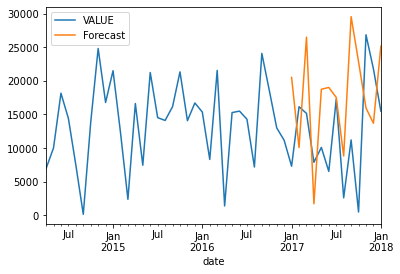

In [277]:
Forecast_Himachal_dataset.plot()

In [278]:
train=np.log(train_Haryana_dataset)
arimaModel_final = ARIMA((1,0,0), (0,1,0,12)).fit(train)
Forecast = pd.Series(arimaModel_final.predict(13))
Forecast = np.exp(Forecast)
Forecast.index = test_Haryana_dataset.index
Forecast
Forecast_Haryana_dataset = pd.concat([Haryana_dataset, Forecast], axis = 1)
Forecast_Haryana_dataset.rename(columns={0:"Forecast"},inplace=True)

<AxesSubplot:xlabel='date'>

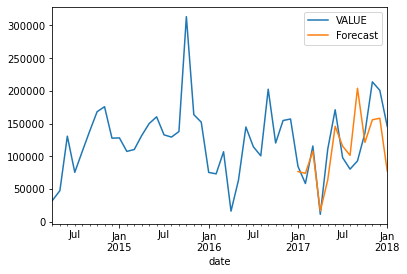

In [279]:
Forecast_Haryana_dataset.plot()

In [280]:
train=np.log(train_Punjab_dataset)
arimaModel_final = ARIMA((1,0,0), (0,1,0,12)).fit(train)
Forecast = pd.Series(arimaModel_final.predict(13))
Forecast = np.exp(Forecast)
Forecast.index = test_Punjab_dataset.index
Forecast
Forecast_Punjab_dataset = pd.concat([Punjab_dataset, Forecast], axis = 1)
Forecast_Punjab_dataset.rename(columns={0:"Forecast"},inplace=True)

<AxesSubplot:xlabel='date'>

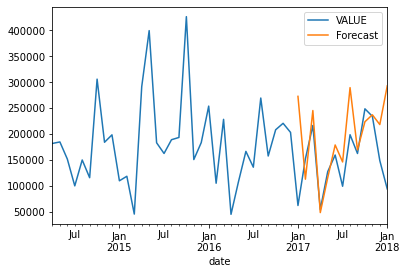

In [282]:
Forecast_Punjab_dataset.plot()

In [283]:
train=np.log(train_Uttarakhand_dataset)
arimaModel_final = ARIMA((1,0,0), (0,1,0,12)).fit(train)
Forecast = pd.Series(arimaModel_final.predict(13))
Forecast = np.exp(Forecast)
Forecast.index = test_Uttarakhand_dataset.index
Forecast
Forecast_Uttarakhand_dataset = pd.concat([Uttarakhand_dataset, Forecast], axis = 1)
Forecast_Uttarakhand_dataset.rename(columns={0:"Forecast"},inplace=True)

<AxesSubplot:xlabel='date'>

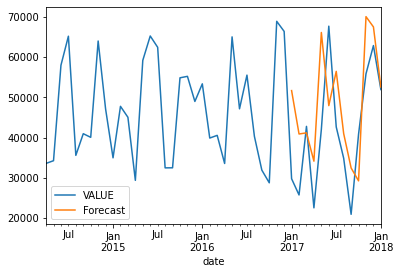

In [285]:
Forecast_Uttarakhand_dataset.plot()

In [287]:
train=np.log(train_Uttar_Pradesh_dataset)
arimaModel_final = ARIMA((1,0,0), (0,1,0,12)).fit(train)
Forecast = pd.Series(arimaModel_final.predict(13))
Forecast = np.exp(Forecast)
Forecast.index = test_Uttar_Pradesh_dataset.index
Forecast
Forecast_Uttar_Pradesh_dataset = pd.concat([Uttar_Pradesh_dataset, Forecast], axis = 1)
Forecast_Uttar_Pradesh_dataset.rename(columns={0:"Forecast"},inplace=True)

<AxesSubplot:xlabel='date'>

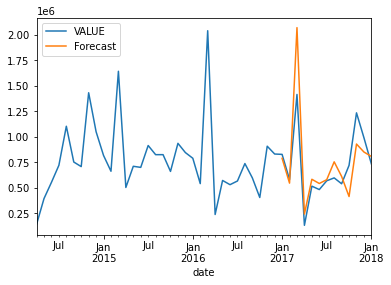

In [289]:
Forecast_Uttar_Pradesh_dataset.plot()